# **Klasifikasi Gambar Sayuran**

## **Objective:**   
Membangun sebuah model menggunakan CNN yang dapat mengklasifikasikan Sayuran.

**vegetable types:** bean, bitter gourd, bottle gourd, brinjal, broccoli, cabbage, capsicum, carrot, cauliflower, cucumber, papaya, potato, pumpkin, radish and tomato..
## **Sumber Dataset**
https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset

# **Import Libraries**

In [1]:
!pip install -q gdown
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
# Sistem & File
import os, shutil, zipfile, random

# Download File
import gdown

# Manipulasi Data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# **Data Loading**

## **Download & Ekstrak File ZIP dari Google Drive**

In [3]:
# Link Google Drive file (ubah ID-nya)
gdrive_url = "https://drive.google.com/uc?id=1jldACuGXJ6_yv5TW_tTUC_H8CtkUS7rX"
output_zip = "vegetable_dataset.zip"

# Unduh file
gdown.download(gdrive_url, output_zip, quiet=False)

# Ekstrak ZIP
extract_path = "vegetable_dataset"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Berhasil mengunduh dan mengekstrak dataset!")

Downloading...
From (original): https://drive.google.com/uc?id=1jldACuGXJ6_yv5TW_tTUC_H8CtkUS7rX
From (redirected): https://drive.google.com/uc?id=1jldACuGXJ6_yv5TW_tTUC_H8CtkUS7rX&confirm=t&uuid=9490233f-c420-4e5b-9b33-d3567b28a654
To: /content/vegetable_dataset.zip
100%|██████████| 560M/560M [00:08<00:00, 64.7MB/s]


✅ Berhasil mengunduh dan mengekstrak dataset!


In [4]:
# Path awal
extract_path = "vegetable_dataset"  # sesuai folder ekstraksi kamu
base_dir = os.path.join(extract_path, "Vegetable Images")

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

# Path gabungan
combined_dir = os.path.join(extract_path, "combined")
os.makedirs(combined_dir, exist_ok=True)

# Fungsi untuk salin semua gambar dari satu dataset ke folder gabungan
def copy_images_to_combined(src_dir, dest_dir):
    for label in os.listdir(src_dir):
        label_path = os.path.join(src_dir, label)
        if os.path.isdir(label_path):
            dest_label_path = os.path.join(dest_dir, label)
            os.makedirs(dest_label_path, exist_ok=True)
            for image_name in os.listdir(label_path):
                src_image = os.path.join(label_path, image_name)
                dest_image = os.path.join(dest_label_path, image_name)
                shutil.copy2(src_image, dest_image)

# Salin dari train, val, dan test ke combined
copy_images_to_combined(train_dir, combined_dir)
copy_images_to_combined(val_dir, combined_dir)
copy_images_to_combined(test_dir, combined_dir)

print("✅ Dataset train, validation, dan test berhasil digabung ke dalam folder:", combined_dir)


✅ Dataset train, validation, dan test berhasil digabung ke dalam folder: vegetable_dataset/combined


## **Load Gambar Dataset**

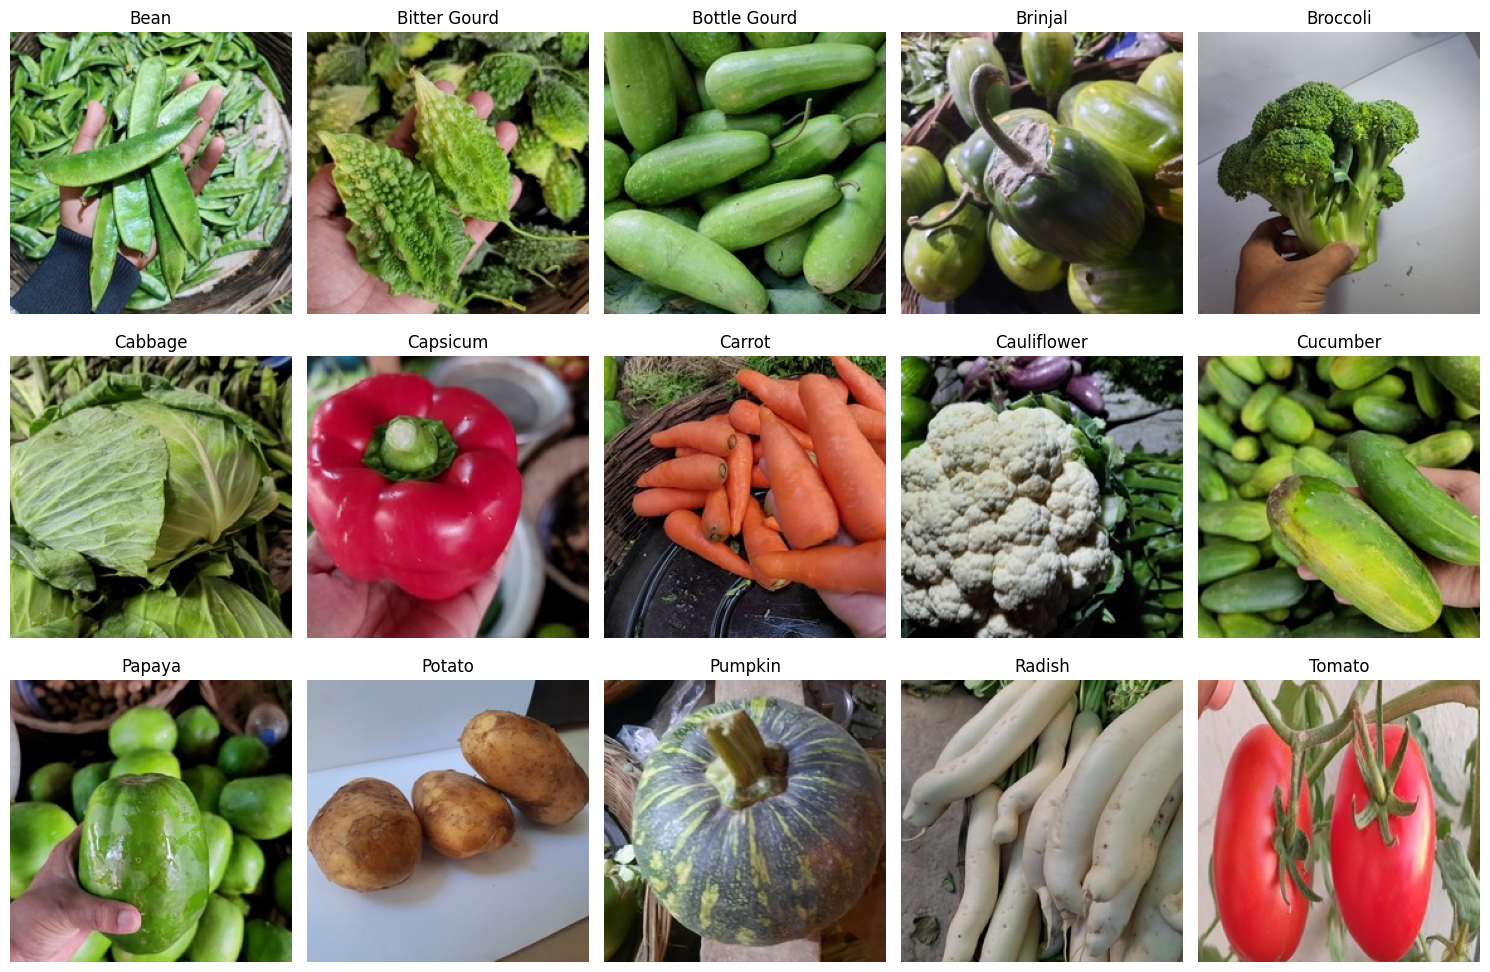

In [5]:
# Path ke folder gabungan
combined_path = os.path.join(extract_path, "combined")

# Ambil semua nama kelas
class_names = sorted([name for name in os.listdir(combined_path) if os.path.isdir(os.path.join(combined_path, name))])

# Plot gambar dari setiap kelas
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(class_names):
    class_folder = os.path.join(combined_path, class_name)
    images = os.listdir(class_folder)
    if images:
        img_path = os.path.join(class_folder, random.choice(images))
        img = Image.open(img_path)

        plt.subplot(3, 5, i + 1)  # Sesuaikan jumlah baris x kolom sesuai jumlah kelas
        plt.imshow(img)
        plt.title(class_name.replace("_", " ").title())
        plt.axis("off")

plt.tight_layout()
plt.show()

## **Plot distribusi gambar di seluruh kelas**

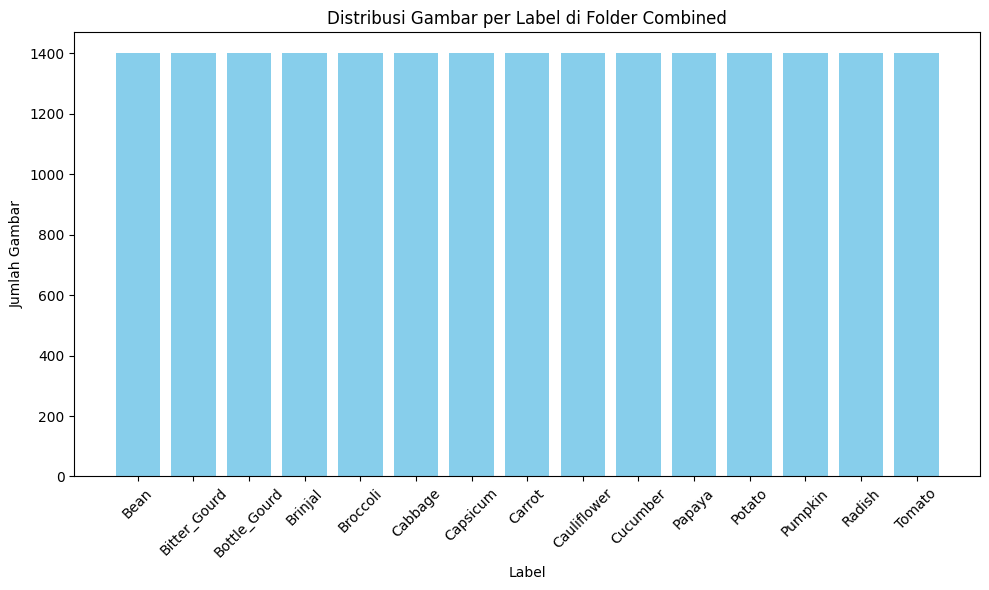

Total semua gambar di folder combined: 21000


In [6]:
# Hitung jumlah gambar per label
label_counts = {}
for label in sorted(os.listdir(combined_path)):
    label_path = os.path.join(combined_path, label)
    if os.path.isdir(label_path):
        count = len(os.listdir(label_path))
        label_counts[label] = count

# Plot distribusi
plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.title("Distribusi Gambar per Label di Folder Combined")
plt.xlabel("Label")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Jumlah total gambar
total_images = sum(label_counts.values())
print(f"Total semua gambar di folder combined: {total_images}")

# **Data Preparation**

## **Data Splitting : Training, Validation, and Testing**

In [7]:
# Path utama ke folder combined
mypath = 'vegetable_dataset/combined'

# Kumpulkan semua path gambar dan label
file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(os.path.basename(path))  # nama folder = label
        file_name.append(name)

# Buat DataFrame
df = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

In [8]:
# Stratified split 80% train, 20% sisa
df_train, df_temp = train_test_split(df, test_size=0.2, stratify=df["labels"], random_state=42)

# Split sisa (20%) jadi val dan test: masing-masing 50% dari 20% = 10%
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp["labels"], random_state=42)

# Cek jumlah data
print("Train:", len(df_train))
print("Validation:", len(df_val))
print("Test:", len(df_test))

Train: 16800
Validation: 2100
Test: 2100


## **Data Preparation (Label, Augmentasi, Normalisasi, Weight Class, Image Generator)**

In [9]:
# Label Encoding
le = LabelEncoder()
le.fit(df_train['labels'])

df_train['labels'] = le.transform(df_train['labels'])
df_val['labels'] = le.transform(df_val['labels'])
df_test['labels'] = le.transform(df_test['labels'])

class_names = le.classes_
num_classes = len(class_names)

# Fungsi untuk memuat dan augmentasi gambar (train only)
def load_image_train(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = img / 255.0

    # Augmentasi
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, 0.9, 1.1)

    return img, label

def load_image_val(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = img / 255.0
    return img, label

# Dataset
train_ds = tf.data.Dataset.from_tensor_slices((df_train["path"].values, df_train["labels"].values))
val_ds = tf.data.Dataset.from_tensor_slices((df_val["path"].values, df_val["labels"].values))
test_ds = tf.data.Dataset.from_tensor_slices((df_test["path"].values, df_test["labels"].values))

train_ds = train_ds.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(load_image_val, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(load_image_val, num_parallel_calls=tf.data.AUTOTUNE)

BATCH_SIZE = 32
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [10]:
# Hitung class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_train['labels']),
    y=df_train['labels']
)
class_weights = dict(enumerate(class_weights))

# **Model Exp 1 - CNN Architecture (Using 32 Filters in Conv Layer):**

In [11]:
# Clear Session
tf.keras.backend.clear_session()

# Model
model1 = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    Conv2D(32, (4, 4), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    Conv2D(32, (7, 7), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(32, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

model1.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │           495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,283,919 (12.53 MB)

 Trainable params: 3,283,727 (12.53 MB)

 Non-trainable params: 192 (768.00 B)

In [12]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

# Training
history = model1.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights
)

Epoch 1/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2102 - loss: 2.5782
Epoch 1: val_accuracy improved from -inf to 0.49190, saving model to best_model.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - accuracy: 0.2103 - loss: 2.5776 - val_accuracy: 0.4919 - val_loss: 1.7221
Epoch 2/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4264 - loss: 1.7945
Epoch 2: val_accuracy improved from 0.49190 to 0.74857, saving model to best_model.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 31s 56ms/step - accuracy: 0.4264 - loss: 1.7943 - val_accuracy: 0.7486 - val_loss: 1.0460
Epoch 3/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5445 - loss: 1.4520
Epoch 3: val_accuracy improved from 0.74857 to 0.82238, saving model to best_model.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 42s 57ms/step - accuracy: 0.5445 - loss: 1.4519 - val_accuracy: 0.8224 - val_loss: 0.7083
Epoch 4/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6221 - loss: 1.2284
Epoch 4: val_accuracy improved from 0.82238 to 0.84524, saving model to best_model.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 38s 69ms/step - accuracy: 0.6221 - loss: 1.2282 - val_accuracy: 0.8452 - val_loss: 0.6320
Epoch 5/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6887 - loss: 1.0136
Epoch 5: val_accuracy improved from 0.84524 to 0.88476, saving model to best_model.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 33s 56ms/step - accuracy: 0.6887 - loss: 1.0136 - val_accuracy: 0.8848 - val_loss: 0.4732
Epoch 6/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7262 - loss: 0.8909
Epoch 6: val_accuracy did not improve from 0.88476
525/525 ━━━━━━━━━━━━━━━━━━━━ 31s 56ms/step - accuracy: 0.7262 - loss: 0.8908 - val_accuracy: 0.8786 - val_loss: 0.4435
Epoch 7/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7459 - loss: 0.8339
Epoch 7: val_accuracy did not improve from 0.88476
525/525 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - accuracy: 0.7460 - loss: 0.8338 - val_accuracy: 0.8390 - val_loss: 0.6096
Epoch 8/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7910 - loss: 0.6969
Epoch 8: val_accuracy improved from 0.88476 to 0.92619, saving model to best_model.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.7910 - loss: 0.6969 - val_accuracy: 0.9262 - val_loss: 0.3064
Epoch 9/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8139 - loss: 0.6280
Epoch 9: val_accuracy did not improve from 0.92619
525/525 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - accuracy: 0.8139 - loss: 0.6279 - val_accuracy: 0.9200 - val_loss: 0.3039
Epoch 10/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8248 - loss: 0.5794
Epoch 10: val_accuracy did not improve from 0.92619
525/525 ━━━━━━━━━━━━━━━━━━━━ 42s 59ms/step - accuracy: 0.8248 - loss: 0.5794 - val_accuracy: 0.9071 - val_loss: 0.3364
Epoch 11/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8384 - loss: 0.5352
Epoch 11: val_accuracy improved from 0.92619 to 0.93714, saving model to best_model.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - accuracy: 0.8384 - loss: 0.5352 - val_accuracy: 0.9371 - val_loss: 0.2529
Epoch 12/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8496 - loss: 0.5073
Epoch 12: val_accuracy improved from 0.93714 to 0.94952, saving model to best_model.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 31s 57ms/step - accuracy: 0.8496 - loss: 0.5073 - val_accuracy: 0.9495 - val_loss: 0.2313
Epoch 13/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8593 - loss: 0.4801
Epoch 13: val_accuracy did not improve from 0.94952
525/525 ━━━━━━━━━━━━━━━━━━━━ 31s 57ms/step - accuracy: 0.8593 - loss: 0.4800 - val_accuracy: 0.9495 - val_loss: 0.2058
Epoch 14/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8704 - loss: 0.4450
Epoch 14: val_accuracy did not improve from 0.94952
525/525 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.8705 - loss: 0.4450 - val_accuracy: 0.9471 - val_loss: 0.2130
Epoch 15/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8830 - loss: 0.4101
Epoch 15: val_accuracy improved from 0.94952 to 0.96476, saving model to best_model.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 31s 58ms/step - accuracy: 0.8830 - loss: 0.4101 - val_accuracy: 0.9648 - val_loss: 0.1663
Epoch 16/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8933 - loss: 0.3715
Epoch 16: val_accuracy did not improve from 0.96476
525/525 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - accuracy: 0.8933 - loss: 0.3715 - val_accuracy: 0.9429 - val_loss: 0.2426
Epoch 17/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8987 - loss: 0.3602
Epoch 17: val_accuracy did not improve from 0.96476
525/525 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.8987 - loss: 0.3602 - val_accuracy: 0.9619 - val_loss: 0.2042
Epoch 18/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8997 - loss: 0.3373
Epoch 18: val_accuracy did not improve from 0.96476
525/525 ━━━━━━━━━━━━━━━━━━━━ 31s 57ms/step - accuracy: 0.8997 - loss: 0.3372 - val_accuracy: 0.9433 - val_loss: 0.2442
Epoch 19/50
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8957 - loss: 0.3804
Epoch 19: val_ac

525/525 ━━━━━━━━━━━━━━━━━━━━ 42s 57ms/step - accuracy: 0.9132 - loss: 0.2804 - val_accuracy: 0.9671 - val_loss: 0.1333
Epoch 21/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9090 - loss: 0.2876
Epoch 21: val_accuracy did not improve from 0.96714
525/525 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - accuracy: 0.9090 - loss: 0.2876 - val_accuracy: 0.9595 - val_loss: 0.1601
Epoch 22/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9232 - loss: 0.2546
Epoch 22: val_accuracy did not improve from 0.96714
525/525 ━━━━━━━━━━━━━━━━━━━━ 30s 57ms/step - accuracy: 0.9232 - loss: 0.2547 - val_accuracy: 0.9533 - val_loss: 0.1847
Epoch 23/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9148 - loss: 0.2913
Epoch 23: val_accuracy improved from 0.96714 to 0.97143, saving model to best_model.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 31s 57ms/step - accuracy: 0.9148 - loss: 0.2913 - val_accuracy: 0.9714 - val_loss: 0.1421
Epoch 24/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9250 - loss: 0.2584
Epoch 24: val_accuracy improved from 0.97143 to 0.97286, saving model to best_model.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.9250 - loss: 0.2584 - val_accuracy: 0.9729 - val_loss: 0.1286
Epoch 25/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9304 - loss: 0.2458
Epoch 25: val_accuracy did not improve from 0.97286
525/525 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.9304 - loss: 0.2458 - val_accuracy: 0.9695 - val_loss: 0.1293
Epoch 26/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9341 - loss: 0.2315
Epoch 26: val_accuracy did not improve from 0.97286
525/525 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - accuracy: 0.9341 - loss: 0.2315 - val_accuracy: 0.9681 - val_loss: 0.1499
Epoch 27/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9351 - loss: 0.2298
Epoch 27: val_accuracy did not improve from 0.97286
525/525 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - accuracy: 0.9351 - loss: 0.2298 - val_accuracy: 0.9576 - val_loss: 0.1710
Epoch 28/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9397 - loss: 0.2175
Epoch 28: val_ac

525/525 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - accuracy: 0.9406 - loss: 0.2163 - val_accuracy: 0.9738 - val_loss: 0.1073
Epoch 32/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9452 - loss: 0.1831
Epoch 32: val_accuracy did not improve from 0.97381
525/525 ━━━━━━━━━━━━━━━━━━━━ 31s 57ms/step - accuracy: 0.9452 - loss: 0.1831 - val_accuracy: 0.9605 - val_loss: 0.1716
Epoch 33/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9450 - loss: 0.1875
Epoch 33: val_accuracy did not improve from 0.97381
525/525 ━━━━━━━━━━━━━━━━━━━━ 31s 56ms/step - accuracy: 0.9449 - loss: 0.1876 - val_accuracy: 0.9476 - val_loss: 0.2489
Epoch 34/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9429 - loss: 0.1994
Epoch 34: val_accuracy did not improve from 0.97381
525/525 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - accuracy: 0.9429 - loss: 0.1994 - val_accuracy: 0.9671 - val_loss: 0.1319
Epoch 35/50
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9509 - loss: 0.1720
Epoch 35: val_ac

525/525 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - accuracy: 0.9544 - loss: 0.1575 - val_accuracy: 0.9748 - val_loss: 0.1180
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 31.


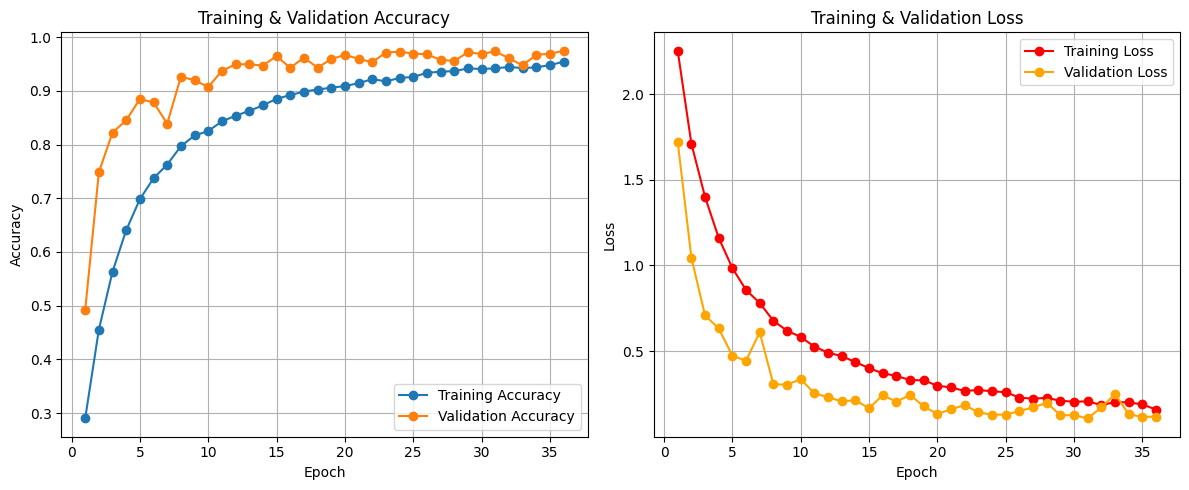

In [13]:
# Plot Akurasi
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o', color='orange')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Accuracy: 0.9714
F1-score (Macro): 0.9716
F1-score (Micro): 0.9714
F1-score (Weighted): 0.9716


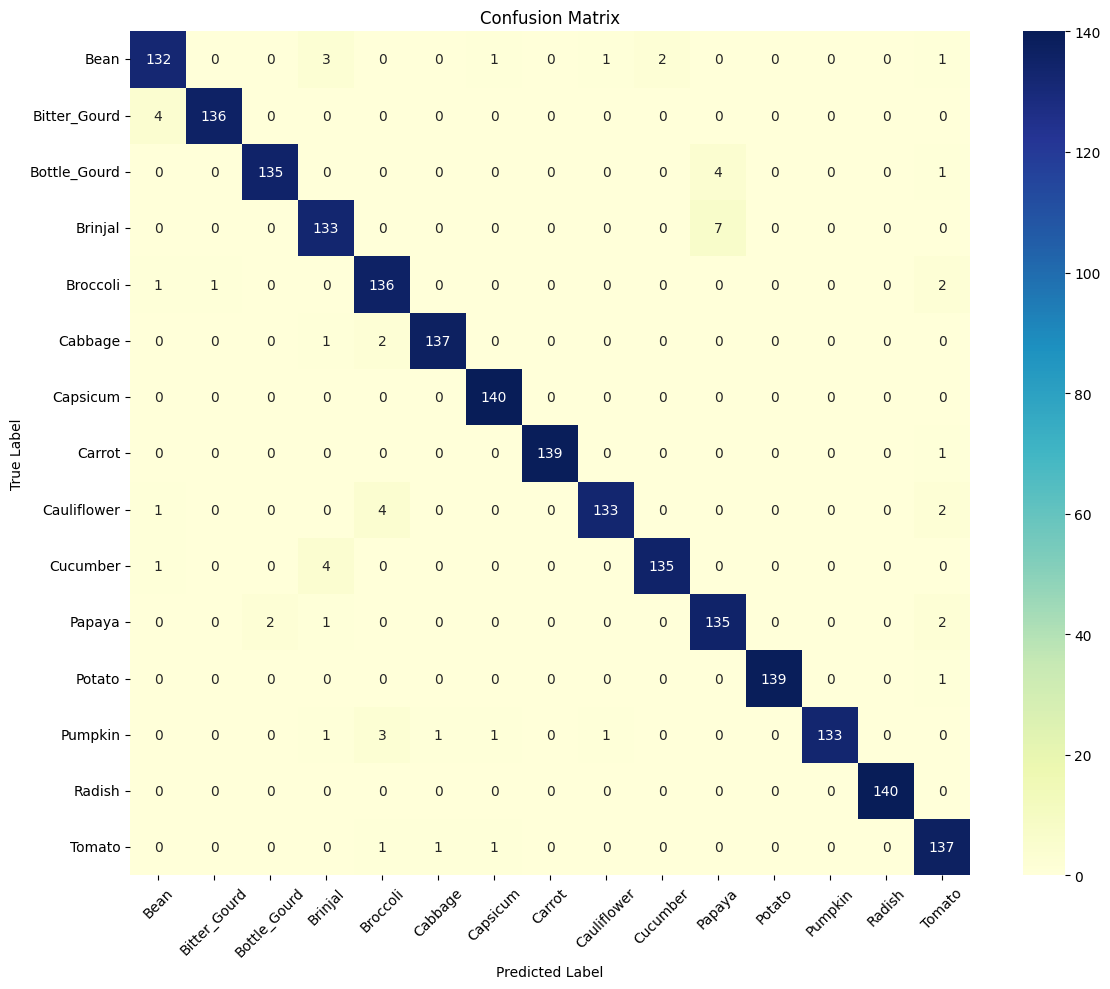


Classification Report:
              precision    recall  f1-score   support

        Bean     0.9496    0.9429    0.9462       140
Bitter_Gourd     0.9927    0.9714    0.9819       140
Bottle_Gourd     0.9854    0.9643    0.9747       140
     Brinjal     0.9301    0.9500    0.9399       140
    Broccoli     0.9315    0.9714    0.9510       140
     Cabbage     0.9856    0.9786    0.9821       140
    Capsicum     0.9790    1.0000    0.9894       140
      Carrot     1.0000    0.9929    0.9964       140
 Cauliflower     0.9852    0.9500    0.9673       140
    Cucumber     0.9854    0.9643    0.9747       140
      Papaya     0.9247    0.9643    0.9441       140
      Potato     1.0000    0.9929    0.9964       140
     Pumpkin     1.0000    0.9500    0.9744       140
      Radish     1.0000    1.0000    1.0000       140
      Tomato     0.9320    0.9786    0.9547       140

    accuracy                         0.9714      2100
   macro avg     0.9721    0.9714    0.9716      2100
we

In [14]:
# Evaluasi Model
preds = model1.predict(test_ds, verbose=0)
predicted_classes = tf.argmax(preds, axis=-1).numpy()
true_labels = np.concatenate([label.numpy() for _, label in test_ds])

accuracy = accuracy_score(true_labels, predicted_classes)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score (Macro): {f1_score(true_labels, predicted_classes, average='macro'):.4f}")
print(f"F1-score (Micro): {f1_score(true_labels, predicted_classes, average='micro'):.4f}")
print(f"F1-score (Weighted): {f1_score(true_labels, predicted_classes, average='weighted'):.4f}")

cm = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(true_labels, predicted_classes, target_names=class_names, digits=4))

best_val_acc = max(history.history['val_accuracy'])
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

Model Image Classification dengan CNN menggunakan 32 Filter mendapatkan akurasi testing sebesar 97,14%, dengan f1-score makro sebesar 97,16%, f1-score mikro sebesar 97,14%, dan f1-score weighted sebesar 97,16%, serta memperoleh best validation accuracy sebesar 97,48%.

# **Model Exp 2 - CNN Architecture (Using 64 Filters in Conv Layers)**

In [15]:
# Clear Session
tf.keras.backend.clear_session()

# Model
model2 = Sequential([
    Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    Conv2D(64, (4, 4), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    Conv2D(64, (7, 7), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

model2.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


model2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,700,815 (25.56 MB)

 Trainable params: 6,700,431 (25.56 MB)

 Non-trainable params: 384 (1.50 KB)

In [16]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

# Training
history2 = model2.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights
)

Epoch 1/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.2083 - loss: 2.6066
Epoch 1: val_accuracy improved from -inf to 0.44429, saving model to best_model.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 66s 101ms/step - accuracy: 0.2084 - loss: 2.6059 - val_accuracy: 0.4443 - val_loss: 1.7622
Epoch 2/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4688 - loss: 1.7524
Epoch 2: val_accuracy improved from 0.44429 to 0.75333, saving model to best_model.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 49s 91ms/step - accuracy: 0.4689 - loss: 1.7522 - val_accuracy: 0.7533 - val_loss: 0.9893
Epoch 3/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5789 - loss: 1.4161
Epoch 3: val_accuracy improved from 0.75333 to 0.80571, saving model to best_model.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 82s 92ms/step - accuracy: 0.5790 - loss: 1.4160 - val_accuracy: 0.8057 - val_loss: 0.7427
Epoch 4/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6567 - loss: 1.1988
Epoch 4: val_accuracy improved from 0.80571 to 0.83714, saving model to best_model.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 49s 92ms/step - accuracy: 0.6567 - loss: 1.1988 - val_accuracy: 0.8371 - val_loss: 0.6659
Epoch 5/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7084 - loss: 1.0353
Epoch 5: val_accuracy improved from 0.83714 to 0.85286, saving model to best_model.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 49s 93ms/step - accuracy: 0.7084 - loss: 1.0353 - val_accuracy: 0.8529 - val_loss: 0.6005
Epoch 6/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7468 - loss: 0.9204
Epoch 6: val_accuracy improved from 0.85286 to 0.89429, saving model to best_model.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 49s 92ms/step - accuracy: 0.7468 - loss: 0.9203 - val_accuracy: 0.8943 - val_loss: 0.4341
Epoch 7/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7741 - loss: 0.8276
Epoch 7: val_accuracy improved from 0.89429 to 0.90810, saving model to best_model.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 49s 93ms/step - accuracy: 0.7741 - loss: 0.8276 - val_accuracy: 0.9081 - val_loss: 0.3994
Epoch 8/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7963 - loss: 0.7446
Epoch 8: val_accuracy did not improve from 0.90810
525/525 ━━━━━━━━━━━━━━━━━━━━ 82s 92ms/step - accuracy: 0.7963 - loss: 0.7445 - val_accuracy: 0.9048 - val_loss: 0.4425
Epoch 9/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8026 - loss: 0.7252
Epoch 9: val_accuracy improved from 0.90810 to 0.91810, saving model to best_model.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 83s 94ms/step - accuracy: 0.8026 - loss: 0.7252 - val_accuracy: 0.9181 - val_loss: 0.3643
Epoch 10/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8273 - loss: 0.6392
Epoch 10: val_accuracy improved from 0.91810 to 0.93619, saving model to best_model.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 81s 92ms/step - accuracy: 0.8273 - loss: 0.6391 - val_accuracy: 0.9362 - val_loss: 0.3198
Epoch 11/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8460 - loss: 0.5741
Epoch 11: val_accuracy did not improve from 0.93619
525/525 ━━━━━━━━━━━━━━━━━━━━ 48s 91ms/step - accuracy: 0.8460 - loss: 0.5741 - val_accuracy: 0.9224 - val_loss: 0.3222
Epoch 12/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8552 - loss: 0.5683
Epoch 12: val_accuracy did not improve from 0.93619
525/525 ━━━━━━━━━━━━━━━━━━━━ 50s 94ms/step - accuracy: 0.8552 - loss: 0.5682 - val_accuracy: 0.9348 - val_loss: 0.3142
Epoch 13/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8717 - loss: 0.4956
Epoch 13: val_accuracy improved from 0.93619 to 0.95000, saving model to best_model.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 49s 92ms/step - accuracy: 0.8717 - loss: 0.4956 - val_accuracy: 0.9500 - val_loss: 0.2476
Epoch 14/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8736 - loss: 0.4901
Epoch 14: val_accuracy improved from 0.95000 to 0.95762, saving model to best_model.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 82s 92ms/step - accuracy: 0.8736 - loss: 0.4901 - val_accuracy: 0.9576 - val_loss: 0.2285
Epoch 15/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8801 - loss: 0.4663
Epoch 15: val_accuracy did not improve from 0.95762
525/525 ━━━━━━━━━━━━━━━━━━━━ 50s 94ms/step - accuracy: 0.8801 - loss: 0.4663 - val_accuracy: 0.9533 - val_loss: 0.2390
Epoch 16/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8977 - loss: 0.4203
Epoch 16: val_accuracy improved from 0.95762 to 0.95952, saving model to best_model.h5


525/525 ━━━━━━━━━━━━━━━━━━━━ 82s 95ms/step - accuracy: 0.8977 - loss: 0.4203 - val_accuracy: 0.9595 - val_loss: 0.1898
Epoch 17/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9021 - loss: 0.3851
Epoch 17: val_accuracy did not improve from 0.95952
525/525 ━━━━━━━━━━━━━━━━━━━━ 49s 91ms/step - accuracy: 0.9021 - loss: 0.3852 - val_accuracy: 0.9433 - val_loss: 0.2555
Epoch 18/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8938 - loss: 0.4125
Epoch 18: val_accuracy did not improve from 0.95952
525/525 ━━━━━━━━━━━━━━━━━━━━ 50s 94ms/step - accuracy: 0.8938 - loss: 0.4125 - val_accuracy: 0.9548 - val_loss: 0.2307
Epoch 19/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9047 - loss: 0.3565
Epoch 19: val_accuracy did not improve from 0.95952
525/525 ━━━━━━━━━━━━━━━━━━━━ 49s 91ms/step - accuracy: 0.9047 - loss: 0.3565 - val_accuracy: 0.9586 - val_loss: 0.1828
Epoch 20/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9086 - loss: 0.3574
Epoch 20: val_ac

525/525 ━━━━━━━━━━━━━━━━━━━━ 49s 91ms/step - accuracy: 0.9136 - loss: 0.3260 - val_accuracy: 0.9667 - val_loss: 0.1789
Epoch 24/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9111 - loss: 0.3195
Epoch 24: val_accuracy did not improve from 0.96667
525/525 ━━━━━━━━━━━━━━━━━━━━ 82s 92ms/step - accuracy: 0.9112 - loss: 0.3195 - val_accuracy: 0.9538 - val_loss: 0.1831
Epoch 25/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9224 - loss: 0.2914
Epoch 25: val_accuracy did not improve from 0.96667
525/525 ━━━━━━━━━━━━━━━━━━━━ 83s 94ms/step - accuracy: 0.9224 - loss: 0.2914 - val_accuracy: 0.9362 - val_loss: 0.3197
Epoch 26/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9275 - loss: 0.2803
Epoch 26: val_accuracy did not improve from 0.96667
525/525 ━━━━━━━━━━━━━━━━━━━━ 50s 94ms/step - accuracy: 0.9275 - loss: 0.2803 - val_accuracy: 0.9162 - val_loss: 0.4047
Epoch 27/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9260 - loss: 0.2991
Epoch 27: val_ac

525/525 ━━━━━━━━━━━━━━━━━━━━ 49s 93ms/step - accuracy: 0.9339 - loss: 0.2520 - val_accuracy: 0.9676 - val_loss: 0.1317
Epoch 29/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9368 - loss: 0.2413
Epoch 29: val_accuracy did not improve from 0.96762
525/525 ━━━━━━━━━━━━━━━━━━━━ 82s 92ms/step - accuracy: 0.9368 - loss: 0.2413 - val_accuracy: 0.9595 - val_loss: 0.2502
Epoch 30/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9309 - loss: 0.2699
Epoch 30: val_accuracy did not improve from 0.96762
525/525 ━━━━━━━━━━━━━━━━━━━━ 81s 91ms/step - accuracy: 0.9309 - loss: 0.2699 - val_accuracy: 0.9014 - val_loss: 0.4024
Epoch 31/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9353 - loss: 0.2542
Epoch 31: val_accuracy did not improve from 0.96762
525/525 ━━━━━━━━━━━━━━━━━━━━ 82s 92ms/step - accuracy: 0.9353 - loss: 0.2542 - val_accuracy: 0.9667 - val_loss: 0.2036
Epoch 32/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9410 - loss: 0.2368
Epoch 32: val_ac

525/525 ━━━━━━━━━━━━━━━━━━━━ 52s 97ms/step - accuracy: 0.9389 - loss: 0.2342 - val_accuracy: 0.9767 - val_loss: 0.1115
Epoch 34/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9439 - loss: 0.2136
Epoch 34: val_accuracy did not improve from 0.97667
525/525 ━━━━━━━━━━━━━━━━━━━━ 50s 93ms/step - accuracy: 0.9439 - loss: 0.2136 - val_accuracy: 0.9286 - val_loss: 0.3462
Epoch 35/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9416 - loss: 0.2267
Epoch 35: val_accuracy did not improve from 0.97667
525/525 ━━━━━━━━━━━━━━━━━━━━ 80s 92ms/step - accuracy: 0.9416 - loss: 0.2267 - val_accuracy: 0.9729 - val_loss: 0.1313
Epoch 36/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9418 - loss: 0.2262
Epoch 36: val_accuracy did not improve from 0.97667
525/525 ━━━━━━━━━━━━━━━━━━━━ 82s 92ms/step - accuracy: 0.9418 - loss: 0.2261 - val_accuracy: 0.9743 - val_loss: 0.1300
Epoch 37/50
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9470 - loss: 0.2087
Epoch 37: val_ac

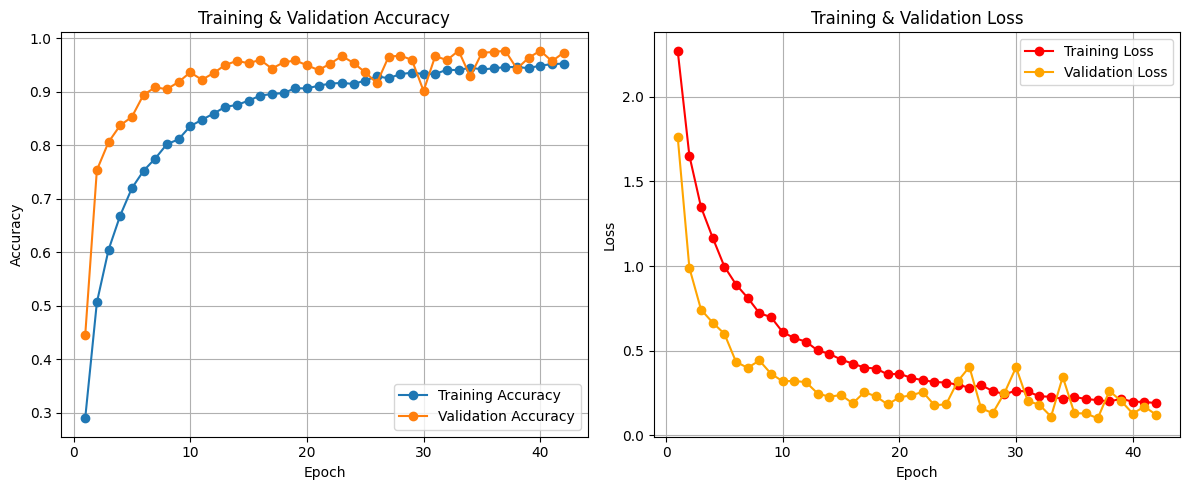

In [17]:
# Plot Akurasi
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o', color='orange')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Accuracy: 0.9800
F1-score (Macro): 0.9801
F1-score (Micro): 0.9800
F1-score (Weighted): 0.9801


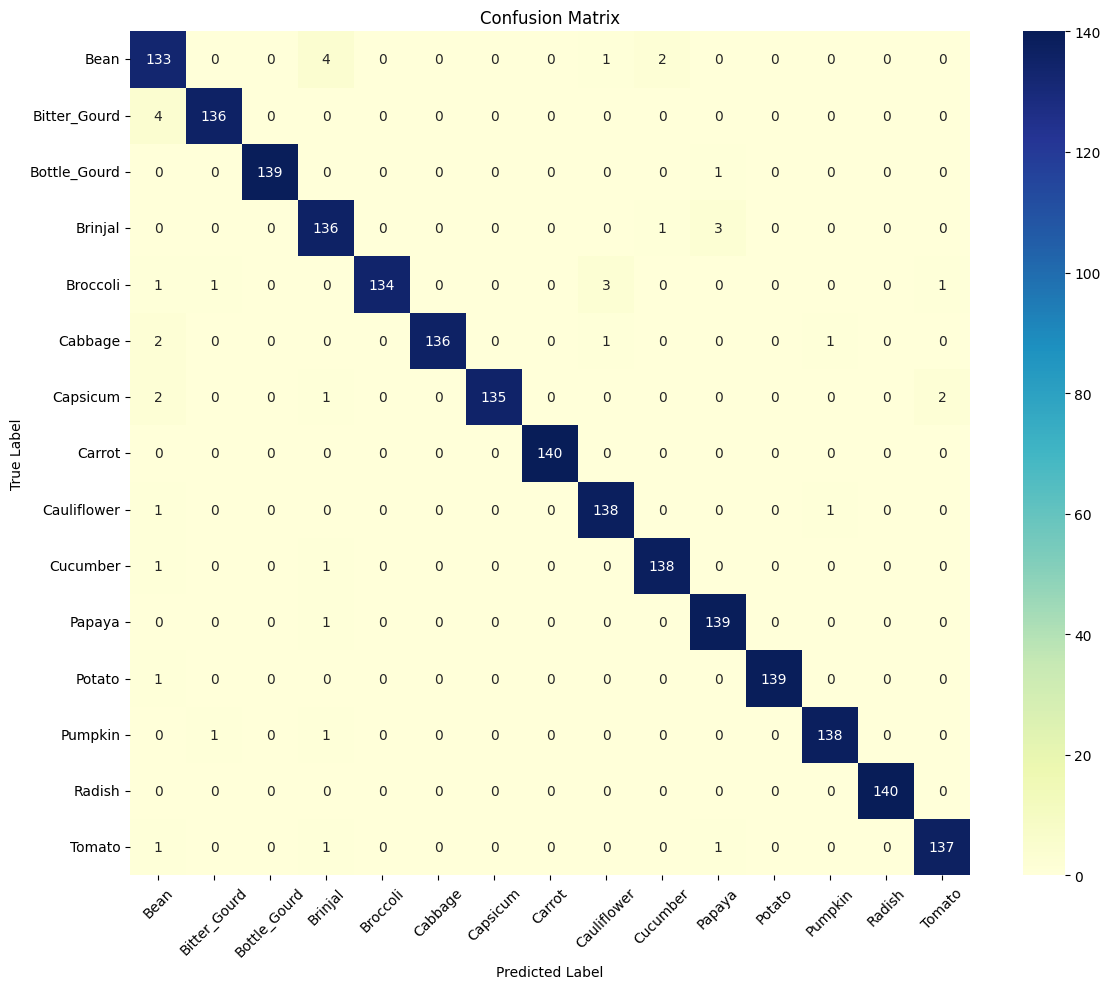


Classification Report:
              precision    recall  f1-score   support

        Bean     0.9110    0.9500    0.9301       140
Bitter_Gourd     0.9855    0.9714    0.9784       140
Bottle_Gourd     1.0000    0.9929    0.9964       140
     Brinjal     0.9379    0.9714    0.9544       140
    Broccoli     1.0000    0.9571    0.9781       140
     Cabbage     1.0000    0.9714    0.9855       140
    Capsicum     1.0000    0.9643    0.9818       140
      Carrot     1.0000    1.0000    1.0000       140
 Cauliflower     0.9650    0.9857    0.9753       140
    Cucumber     0.9787    0.9857    0.9822       140
      Papaya     0.9653    0.9929    0.9789       140
      Potato     1.0000    0.9929    0.9964       140
     Pumpkin     0.9857    0.9857    0.9857       140
      Radish     1.0000    1.0000    1.0000       140
      Tomato     0.9786    0.9786    0.9786       140

    accuracy                         0.9800      2100
   macro avg     0.9805    0.9800    0.9801      2100
we

In [18]:
# Evaluasi Model
preds = model2.predict(test_ds, verbose=0)
predicted_classes = tf.argmax(preds, axis=-1).numpy()
true_labels = np.concatenate([label.numpy() for _, label in test_ds])


accuracy = accuracy_score(true_labels, predicted_classes)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score (Macro): {f1_score(true_labels, predicted_classes, average='macro'):.4f}")
print(f"F1-score (Micro): {f1_score(true_labels, predicted_classes, average='micro'):.4f}")
print(f"F1-score (Weighted): {f1_score(true_labels, predicted_classes, average='weighted'):.4f}")

cm = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


print("\nClassification Report:")
print(classification_report(true_labels, predicted_classes, target_names=class_names, digits=4))


best_val_acc = max(history2.history['val_accuracy'])
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

Model Image Classification dengan CNN menggunakan 64 filter mendapatkan akurasi testing sebesar 98,00%, dengan f1-score makro sebesar 98,01%, f1-score mikro sebesar 98,00%, dan f1-score weighted sebesar 98,01%, serta memperoleh best validation accuracy sebesar 97,67%.

### Kesimpulan:
** Model CNN dengan 64 filter akan digunakan karena model ini menunjukkan performa yang lebih baik dibandingkan model dengan 32 filter. Model dengan 64 filter berhasil mencapai akurasi testing sebesar 98,00% dan f1-score makro sebesar 98,01%, yang lebih tinggi dibandingkan model dengan 32 filter yang hanya mencapai akurasi testing sebesar 97,14% dan f1-score makro sebesar 97,16%. Selain itu, model 64 filter menunjukkan stabilitas performa yang lebih baik pada data testing, sehingga lebih layak digunakan untuk proses deployment ke berbagai platform seperti mobile, web, maupun server.**

# **Menyimpan Model (SavedModel, TF-Lite dan TFJS)**

## Saya akan menggunakan Model Exp 2 - CNN Architecture (Using 64 Filters in Conv Layers)

## Saved Model

In [23]:
# Simpan model2 ke SavedModel
model2.export('saved_model/model2')

Saved artifact at 'saved_model/model2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  132528289603536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132528241173584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132528241169936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132528241172816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132528241170512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132528241173200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132528241175312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132528241175888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132528241176272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132528241174928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13252824117

## TF-Lite

In [24]:
# Konversi ke TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/model2')
tflite_model = converter.convert()

# Buat folder tflite kalau belum ada
import os
os.makedirs('tflite', exist_ok=True)

# Simpan file TFLite
with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

## TFJS

In [27]:
# TensorFlow JS
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    saved_model/model2 \
    model2_tfjs

2025-04-26 13:28:11.507367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745674091.532773   21354 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745674091.539510   21354 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-26 13:28:16.188419: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1745674096.188594   21354 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [32]:
# --- ZIP & DOWNLOAD ---
from google.colab import files

# Zip folder saved_model/model2
!zip -r saved_model_model2.zip saved_model/model2
# Download zip saved_model
files.download('saved_model_model2.zip')

# Zip folder tflite
!zip -r tflite.zip tflite
# Download zip tflite
files.download('tflite.zip')

# Zip folder model2_tfjs
!zip -r model2_tfjs.zip model2_tfjs
# Download zip model2_tfjs
files.download('model2_tfjs.zip')

  adding: saved_model/model2/ (stored 0%)
  adding: saved_model/model2/variables/ (stored 0%)
  adding: saved_model/model2/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: saved_model/model2/variables/variables.index (deflated 71%)
  adding: saved_model/model2/saved_model.pb (deflated 87%)
  adding: saved_model/model2/assets/ (stored 0%)
  adding: saved_model/model2/fingerprint.pb (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: tflite/ (stored 0%)
  adding: tflite/model.tflite (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: model2_tfjs/ (stored 0%)
  adding: model2_tfjs/group1-shard1of7.bin (deflated 7%)
  adding: model2_tfjs/group1-shard2of7.bin (deflated 7%)
  adding: model2_tfjs/group1-shard4of7.bin (deflated 7%)
  adding: model2_tfjs/group1-shard7of7.bin (deflated 7%)
  adding: model2_tfjs/group1-shard5of7.bin (deflated 7%)
  adding: model2_tfjs/group1-shard6of7.bin (deflated 7%)
  adding: model2_tfjs/model.json (deflated 91%)
  adding: model2_tfjs/group1-shard3of7.bin (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Inference/Testing**

Menggunakan TFLite Model

In [28]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")
interpreter.allocate_tensors()

# Dapatkan input & output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:", input_details)
print("Output details:", output_details)

Input details: [{'name': 'serving_default_keras_tensor:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 36, 'shape': array([ 1, 15], dtype=int32), 'shape_signature': array([-1, 15], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [29]:
# Ambil satu batch dari test_ds
for images, labels in test_ds.take(1):
    sample_image = images[0].numpy()
    sample_label = labels[0].numpy()
    break

# Pastikan shape-nya sesuai dengan input model
input_shape = input_details[0]['shape']

# Kalau perlu expand dims (dari (224, 224, 3) ke (1, 224, 224, 3))
input_data = np.expand_dims(sample_image, axis=0).astype(np.float32)

In [30]:
# Set tensor ke interpreter
interpreter.set_tensor(input_details[0]['index'], input_data)

# Jalankan inference
interpreter.invoke()

# Ambil output
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output_data, axis=-1)[0]

# Tampilkan hasil
print(f"True label      : {class_names[sample_label]}")
print(f"Predicted label : {class_names[predicted_class]}")

True label      : Cabbage
Predicted label : Cabbage


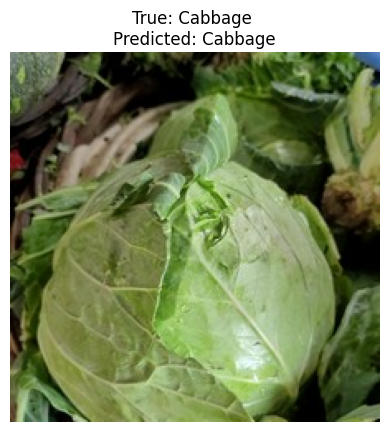

In [31]:
plt.imshow(sample_image)
plt.title(f"True: {class_names[sample_label]} \nPredicted: {class_names[predicted_class]}")
plt.axis('off')
plt.show()